In [1]:
"""
Mount Google Colab Notebook correctly so we are in the correct relative directory
"""
from google.colab import drive
drive.mount('/content/gdrive')
% cd /content/gdrive/My Drive/Github/"CS 499 - SPRING 2022"/"3. Experiments"/"3. COVID_Forecaster"

Mounted at /content/gdrive
/content/gdrive/My Drive/Github/CS 499 - SPRING 2022/3. Experiments/3. COVID_Forecaster


In [2]:
###################################################################################################################################
"""
Ensure we have correct version of Pytorch Geometric before importing or installing anything else
"""
# Code in this cell is courtesy of: https://gist.github.com/ameya98/b193856171d11d37ada46458f60e73e7 
# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch
import os

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 
!pip install torch-geometric-temporal # added for GConvGRU
!pip install ogb

print("PyTorch has version {}".format(torch.__version__))

########################################################################################################################################

"""
Download and Import any other libraries we will use later on
"""

! pip install epiweeks
! pip install haversine

import pickle
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

from torch_geometric.data import Data
from torch.nn import Linear
from torch_geometric.nn import GCNConv 
from torch_geometric_temporal.nn.recurrent import GConvGRU
# from preprocess_data import get_preprocessed_data

##############################################################################################################################################


Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 8.0 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 3.5 MB 6.2 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 2.3 MB 7.5 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 747 kB 1.7 MB/s 
     |████████████████████████████████| 370 kB 7.4 MB/s 
     |████████████████████████████████| 482 kB 42.4 MB/s 
     |████████████████████████████████| 41 kB 615 kB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.3-py3-none-any.whl size=581968 sha256=9c37e6dfa9df444c6b8e95940771281b6efe99ac02eec03690f7d5514dc7cf03
  Stored in directory: /root/.cache/pip/wheels/c3/2a/58/87ce0508964d4def1aafb92750c4f3ac77038efd1b9a89dcf5
Successfully built to

In [3]:
import time
time_start = time.time()

In [4]:
"""
Declare global variables
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
inputLayer_num_features = 36 
hiddenLayer1_num_features = 24
hiddenLayer2_num_features = 24
outputLayer_num_features = 15 # pred_window, redeclared from preprocessing_data
chebyshev_filter_size = 2
history_window = 6 # history_window, redeclared from preprocessing_data 
preprocessed_data_relative_file_path = 'data/preprocessed_data_v3_reorder_input_active_cases.pickle'
save_model_relative_path = './saved_models/v3_2_reorder_skip_and_active_1000_epochs_timed'
numEpochs = 1000
save_predictions_relative_path = './saved_models/v3_2_archived_output_1000_epochs_timed.pickle'

cpu


In [5]:
"""
Get and unpack preprocessed data
"""

# # Get preprocessed data and unpackage variables needed during training/testing/validation
# preprocessed_data = get_preprocessed_data()
# # Save preprocessed data as pickle so we don't have to consecutively re-download the same data (time consuming) when re-running all cells in this notebook
# with open(preprocessed_data_relative_file_path, 'wb') as handle:
#     pickle.dump(preprocessed_data, handle)


# Load in saved preprocessed_data
preprocessed_data = None
with open(preprocessed_data_relative_file_path, 'rb') as handle:
    preprocessed_data = pickle.load(handle)

# Unpack preprocessed data
training_variables = preprocessed_data['training_variables']
validation_variables = preprocessed_data['validation_variables']
testing_variables = preprocessed_data['testing_variables']

edge_index = preprocessed_data['edge_index']

train_x = training_variables['train_x_smoothed']
train_y = training_variables['train_y_active_smoothed']

val_x = validation_variables['val_x_smoothed']
val_y = validation_variables['val_y_active_unsmoothed']

test_x = testing_variables['test_x_smoothed']
test_y = testing_variables['test_y_active_unsmoothed']

In [6]:
"""
Put preprocessed data into "Data" objects and put "Data" objects into tensors on the "device"
"""
training_data = []
validation_data = []
testing_data = []
for i in range(len(train_x)):
  toAppend = Data(x=train_x[i], y=train_y[i], edge_index=edge_index).to(device)
  training_data.append(toAppend)
for i in range(len(val_x)):
  toAppend = Data(x=val_x[i], y=val_y[i], edge_index=edge_index).to(device)
  validation_data.append(toAppend)
for i in range(len(test_x)):
  toAppend = Data(x=test_x[i], y=test_y[i], edge_index=edge_index).to(device)
  testing_data.append(toAppend)

In [7]:
"""
Define network architecture, optimizer, and loss function
Reference: https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html 
"""

class GCN(torch.nn.Module):
    # def __init__(self):
    #     super().__init__()
    #     self.conv1 = GCNConv(inputLayer_num_features, hiddenLayer1_num_features)
    #     self.conv2 = GCNConv(hiddenLayer1_num_features, outputLayer_num_features)

    def __init__(self):
      super().__init__()
      self.conv1 = GConvGRU(in_channels=inputLayer_num_features, out_channels=hiddenLayer1_num_features, K=chebyshev_filter_size)
      self.conv2 = GConvGRU(in_channels=hiddenLayer1_num_features, out_channels=hiddenLayer2_num_features, K=chebyshev_filter_size)
      self.linear1 = Linear(hiddenLayer2_num_features, outputLayer_num_features)
      self.linear2 = Linear(history_window, outputLayer_num_features)
      self.linear3 = Linear(outputLayer_num_features, outputLayer_num_features)

    def forward(self, data):
      x, edge_index = data.x, data.edge_index
      x = self.conv1(x, edge_index)
      x = F.elu(x)
      x = self.conv2(x, edge_index)
      x = F.elu(x)
      x = self.linear1(x) + self.linear2(data.x[:, 0:history_window])

      x = F.elu(x)
      x = self.linear3(x)

      return x

model = GCN().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

criterion = torch.nn.MSELoss()

In [8]:
model

GCN(
  (conv1): GConvGRU(
    (conv_x_z): ChebConv(36, 24, K=2, normalization=sym)
    (conv_h_z): ChebConv(24, 24, K=2, normalization=sym)
    (conv_x_r): ChebConv(36, 24, K=2, normalization=sym)
    (conv_h_r): ChebConv(24, 24, K=2, normalization=sym)
    (conv_x_h): ChebConv(36, 24, K=2, normalization=sym)
    (conv_h_h): ChebConv(24, 24, K=2, normalization=sym)
  )
  (conv2): GConvGRU(
    (conv_x_z): ChebConv(24, 24, K=2, normalization=sym)
    (conv_h_z): ChebConv(24, 24, K=2, normalization=sym)
    (conv_x_r): ChebConv(24, 24, K=2, normalization=sym)
    (conv_h_r): ChebConv(24, 24, K=2, normalization=sym)
    (conv_x_h): ChebConv(24, 24, K=2, normalization=sym)
    (conv_h_h): ChebConv(24, 24, K=2, normalization=sym)
  )
  (linear1): Linear(in_features=24, out_features=15, bias=True)
  (linear2): Linear(in_features=6, out_features=15, bias=True)
  (linear3): Linear(in_features=15, out_features=15, bias=True)
)

In [9]:
"""
Training
"""
min_loss = 1e20

def train():
  total_loss = 0.0
  for data in training_data:
    model.train()
    optimizer.zero_grad()
    predicted_output = model(data)
    labeled_output = data.y.to(device)
    loss = criterion(predicted_output, labeled_output)
    loss.backward()
    total_loss += loss.item()
    optimizer.step()
  return total_loss

def validation():
  model.eval()
  totalLoss = 0.0
  for data_validation in validation_data:
    validation_prediction_output = model(data_validation)
    labeled_validation_output = data_validation.y.to(device)
    loss = criterion(validation_prediction_output, labeled_validation_output)
    totalLoss += loss.item()
  return totalLoss

for epoch in range(numEpochs):
  training_loss = train()
  val_loss = validation()
  if val_loss < min_loss:
    min_loss = val_loss
    state = {
        'state': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    torch.save(state, save_model_relative_path)
    print("==================================================================")
    print("Saved best model")
  print('Epoch %d, Loss %.2f, Val loss %.2f'%(epoch, training_loss, val_loss))

Saved best model
Epoch 0, Loss 24902800278.00, Val loss 196377024.00
Saved best model
Epoch 1, Loss 1755771014.00, Val loss 81956992.00
Saved best model
Epoch 2, Loss 865720121.00, Val loss 59362140.00
Saved best model
Epoch 3, Loss 818720700.00, Val loss 54691400.00
Epoch 4, Loss 815864263.00, Val loss 56262372.00
Saved best model
Epoch 5, Loss 812462576.00, Val loss 54298016.00
Saved best model
Epoch 6, Loss 820676069.00, Val loss 51858152.00
Saved best model
Epoch 7, Loss 832379217.00, Val loss 49701212.00
Saved best model
Epoch 8, Loss 837847508.00, Val loss 47367720.00
Saved best model
Epoch 9, Loss 843760047.00, Val loss 45461028.00
Saved best model
Epoch 10, Loss 846811487.00, Val loss 43979068.00
Saved best model
Epoch 11, Loss 846240063.00, Val loss 42764964.00
Saved best model
Epoch 12, Loss 842584663.00, Val loss 41698108.00
Saved best model
Epoch 13, Loss 836691822.00, Val loss 40710920.00
Saved best model
Epoch 14, Loss 828714526.00, Val loss 39835612.00
Saved best model
E

273689056.0
tensor([2594.1128, 2745.8848, 2900.8577, 3055.9751, 3218.1821, 3389.6340,
        3558.7051, 3724.3987, 3889.5034, 4049.0896, 4210.6846, 4362.2734,
        4494.1250, 4623.9326, 4756.2520], grad_fn=<SelectBackward0>)
tensor([2908., 2871., 3187., 3222., 3421., 3617., 3844., 3908., 3987., 4006.,
        4123., 4544., 4193., 4722., 4866.])


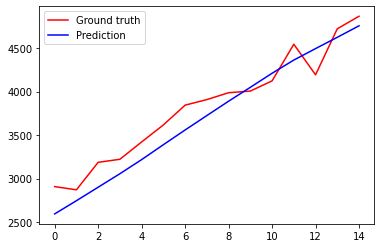

In [10]:
"""
Testing and plotting results
"""

predicted_output = None
labeled_output = None
for data in testing_data:
  model.eval()
  predicted_output = model(data)
  labeled_output = data.y.to(device)
  loss = criterion(predicted_output, labeled_output)
  print(loss.item())

state_num = 29

print(predicted_output[state_num])
print(labeled_output[state_num])

plt.plot(labeled_output[state_num].cpu().detach().numpy(),c='r', label='Ground truth')
plt.plot(predicted_output[state_num].cpu().detach().numpy(),c='b', label='Prediction')
plt.legend()
plt.show()

In [11]:
archived_output = {
     # 'loc_list':loc_list, 
    # 'model_predictions_number_infected_dictionary':model_predictions_number_infected_dictionary, 
    'model_predictions_number_infected_tensor':predicted_output, # (52, 15)
    # 'ground_truth_number_infected_dictionary':ground_truth_number_infected_dictionary, 
    'ground_truth_number_infected_tensor':labeled_output # (52, 15)
}

# Save archived_output as pickle for use later
with open(save_predictions_relative_path, 'wb') as handle:
    pickle.dump(archived_output, handle)


# # Load in archived_output pickle
# archived_output = None
# with open(save_predictions_relative_path, 'rb') as handle:
#     archived_output = pickle.load(handle)


# print(model_predictions_number_infected['Alabama'])
# print(ground_truth_number_infected['Alabama'])

In [12]:
time_end = time.time()
time_seconds = time_end - time_start
(t_min, t_sec) = divmod(time_seconds,60)
(t_hour,t_min) = divmod(t_min,60) 
print('Time passed: {} hours:{} minutes:{} seconds'.format(t_hour,t_min,t_sec))
# Time passed: 0.0 hours:6.0 minutes:50.026517391204834 seconds

Time passed: 0.0 hours:5.0 minutes:45.13369083404541 seconds
